### For ths notebook, all data are for 240s. </br>The angle is between 250-280 degrees. </br>The height of the LIDAR is 29+20 cm and 90+15 cm width

In [1]:
try:
    import numpy as np
except:
    %pip install numpy
      
import pandas as pd
import matplotlib.pyplot as plt
import latexify as lt
import scipy.signal as signal

#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [2]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_30540/2255778309.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,1, figsize=(10,6))


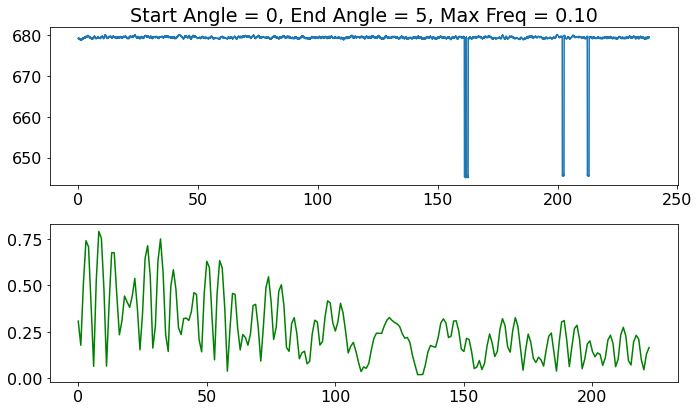

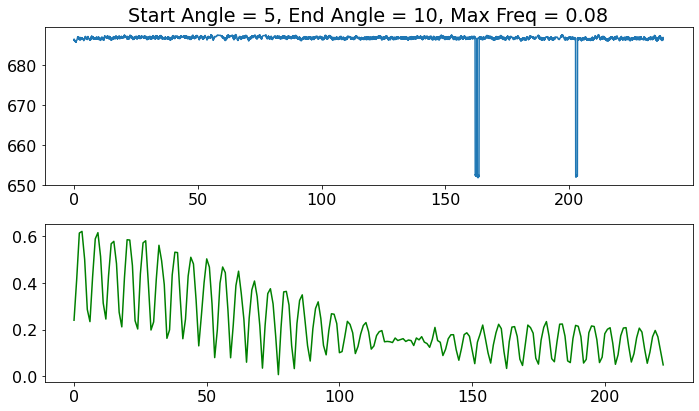

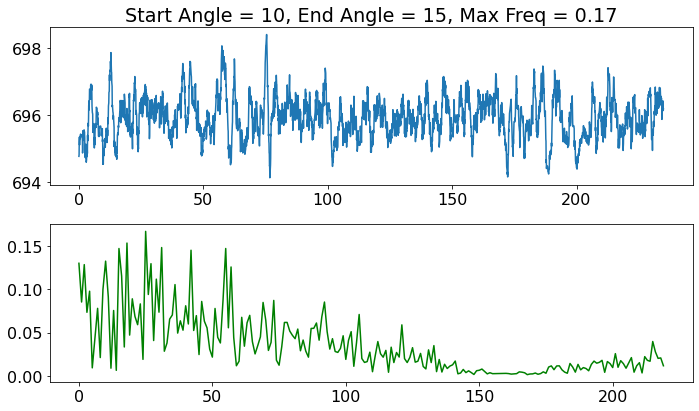

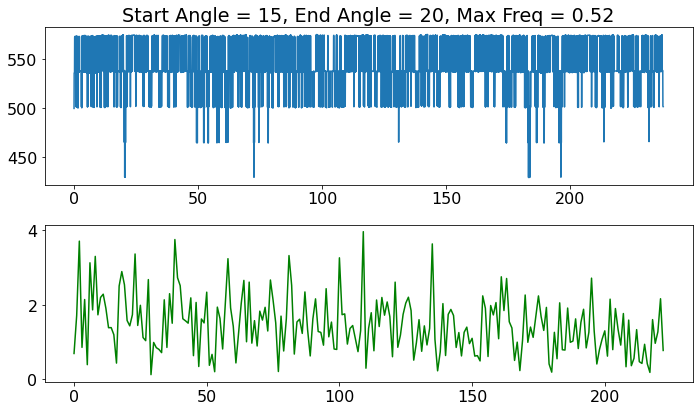

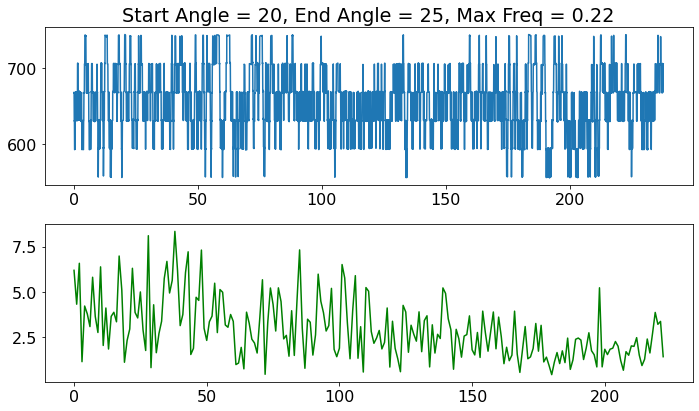

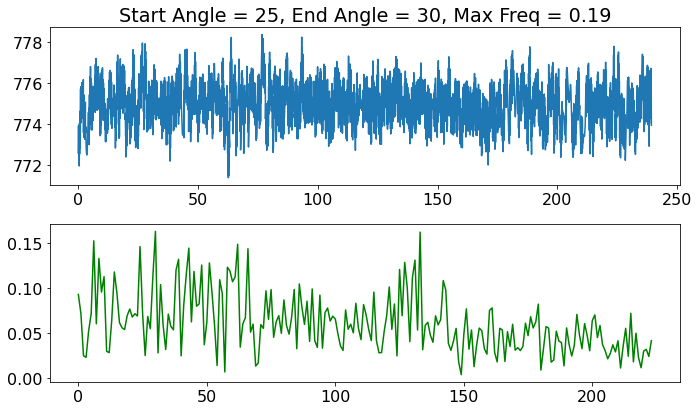

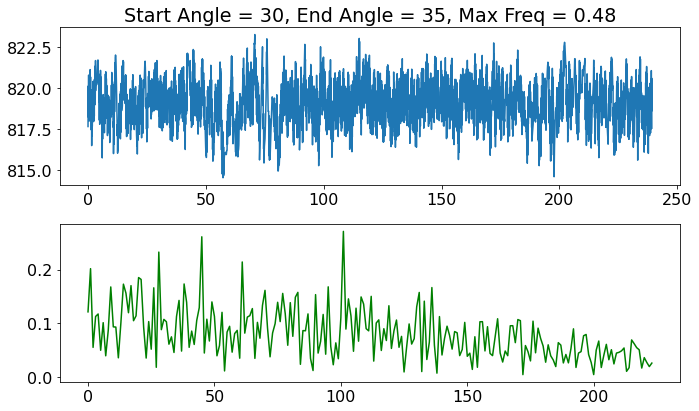

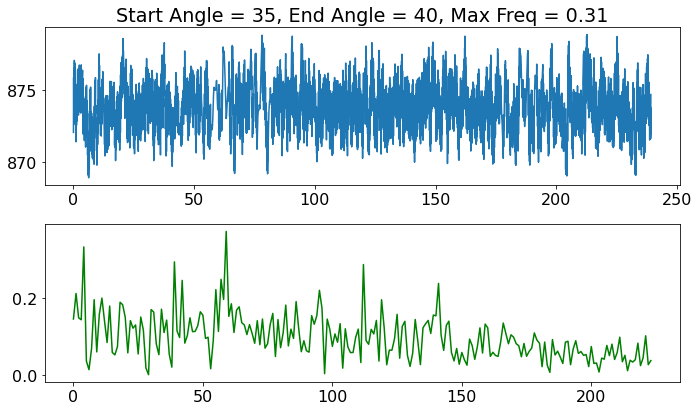

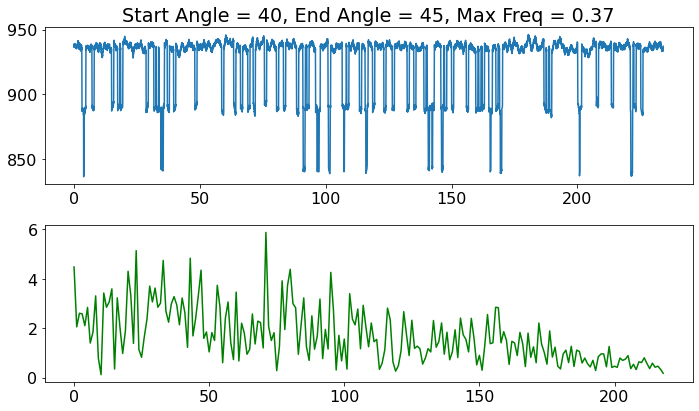

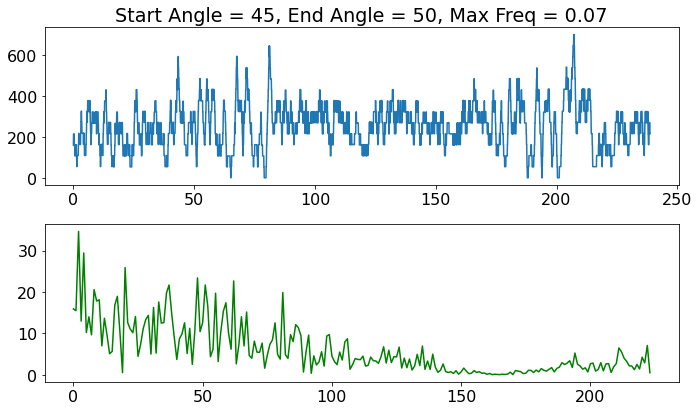

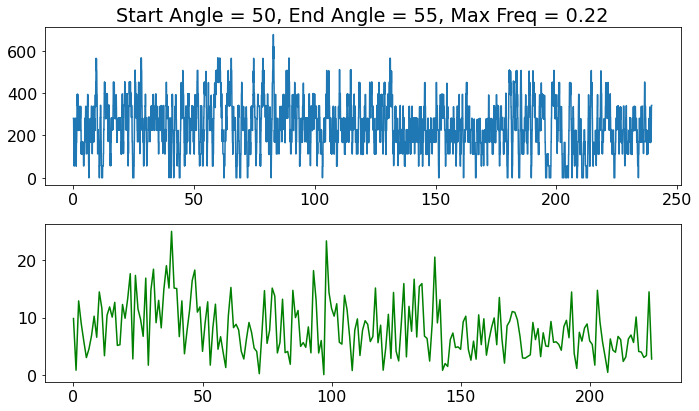

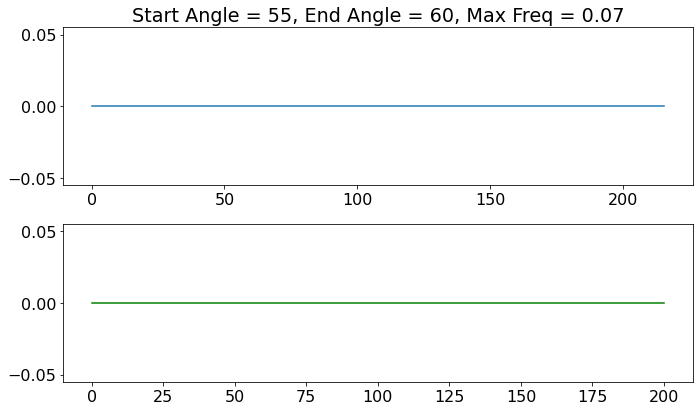

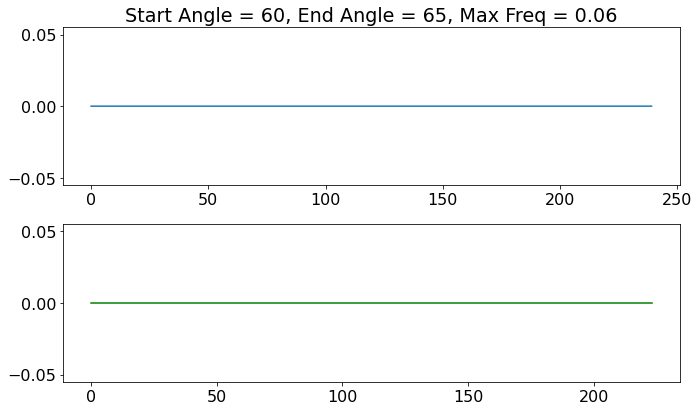

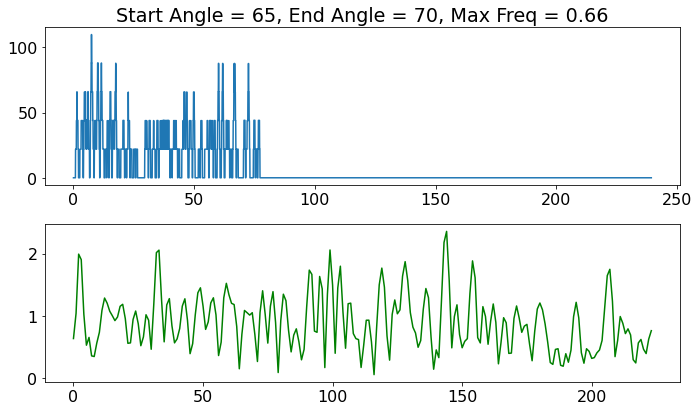

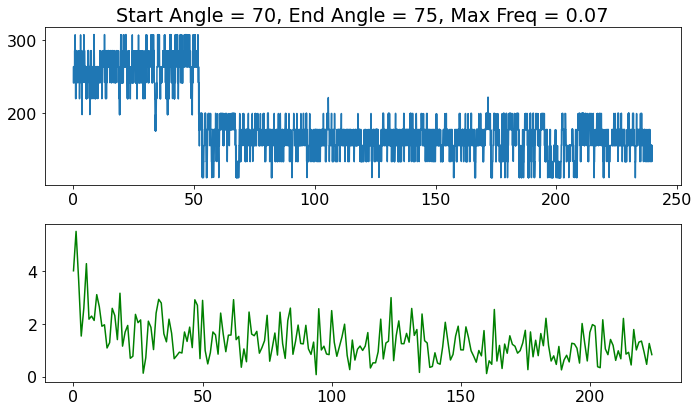

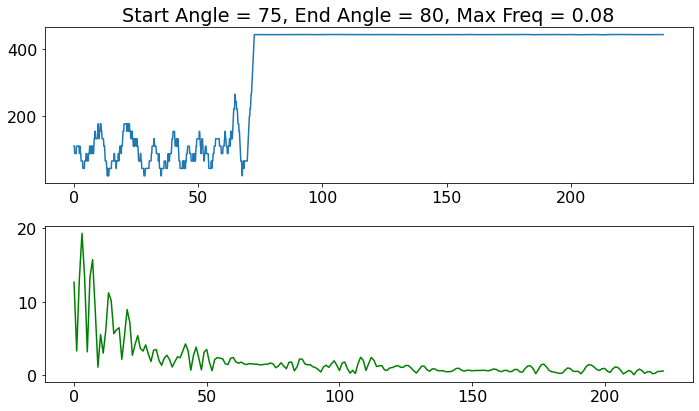

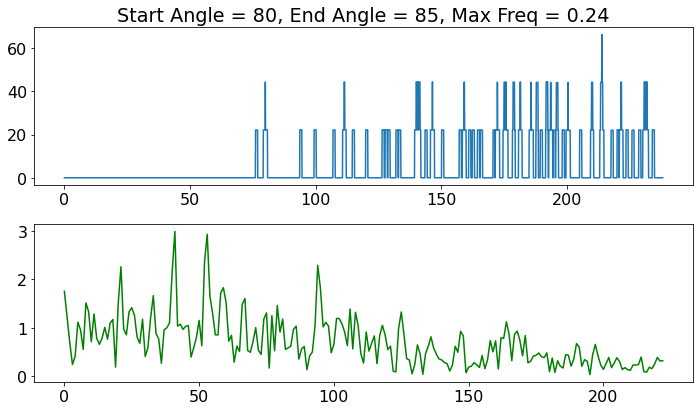

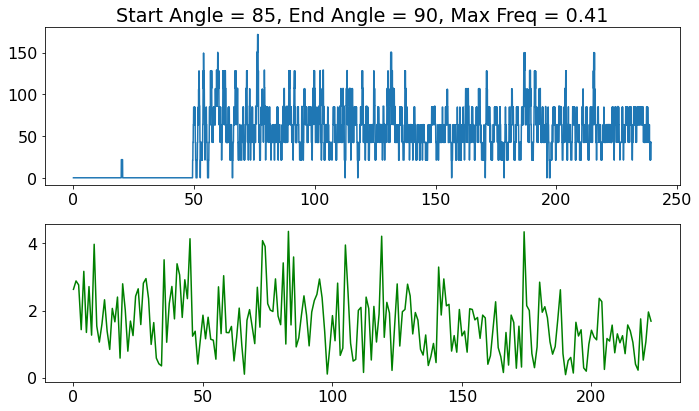

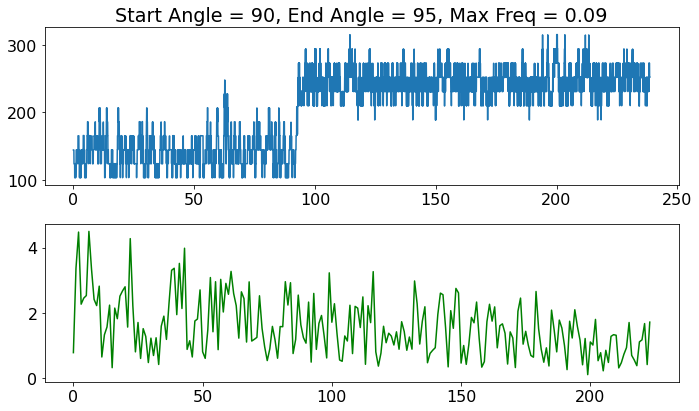

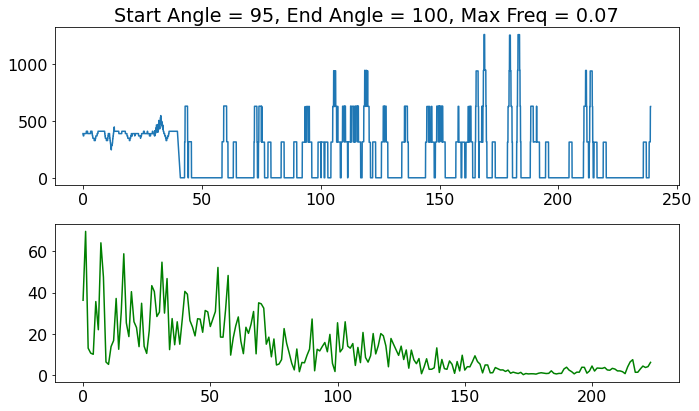

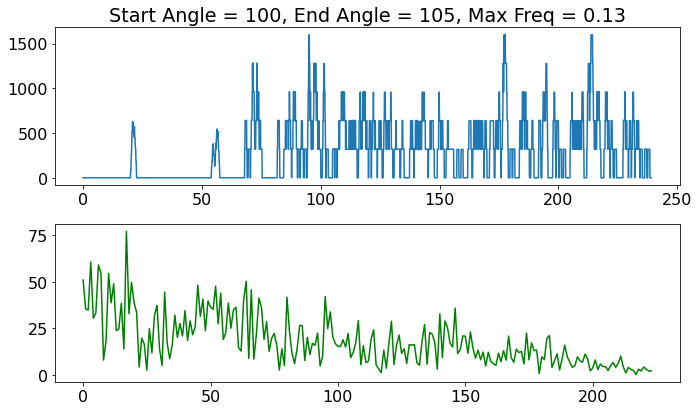

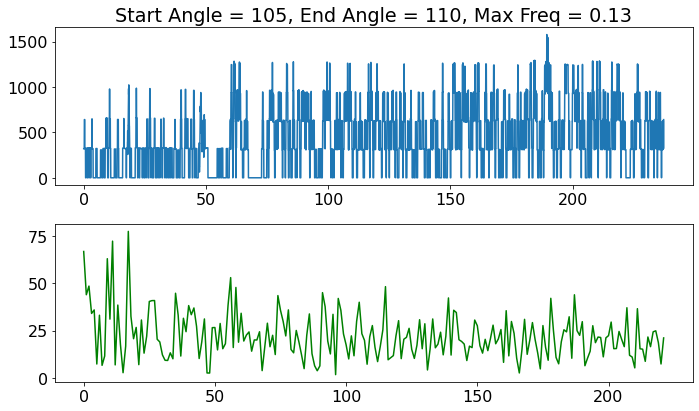

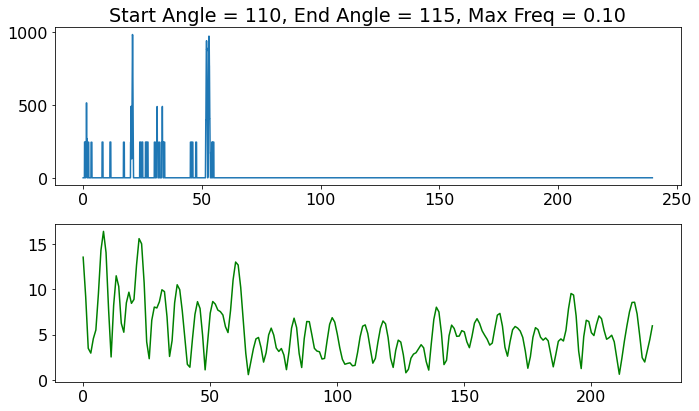

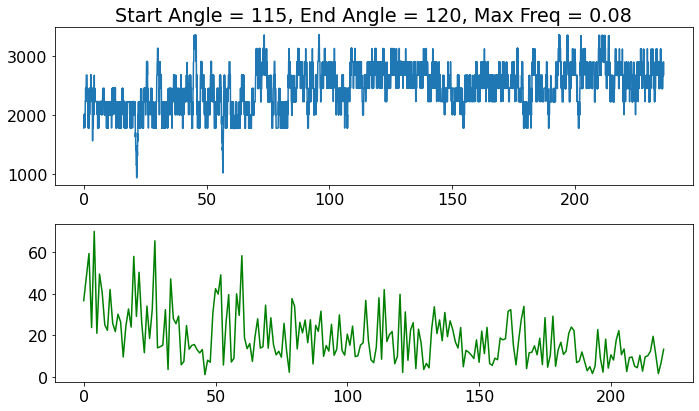

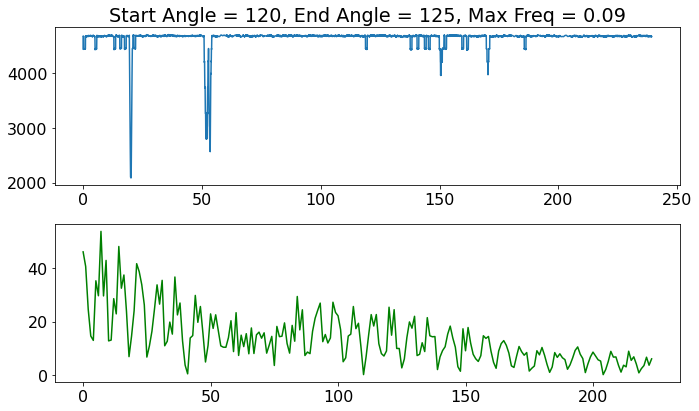

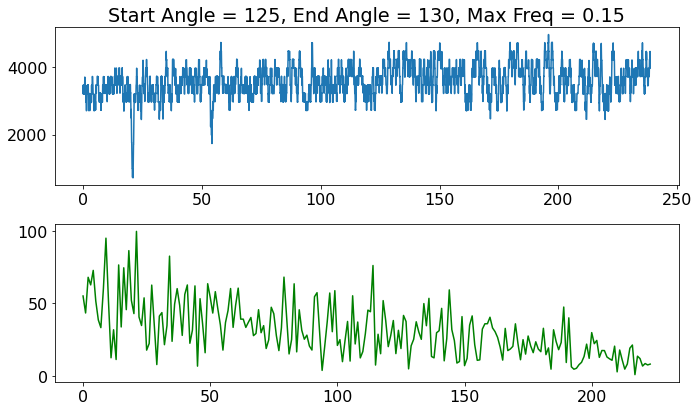

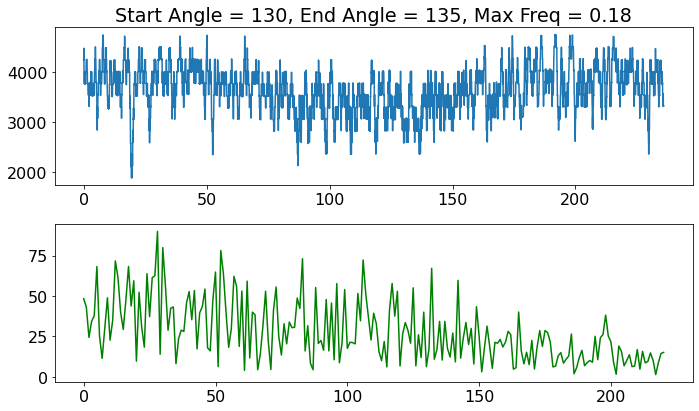

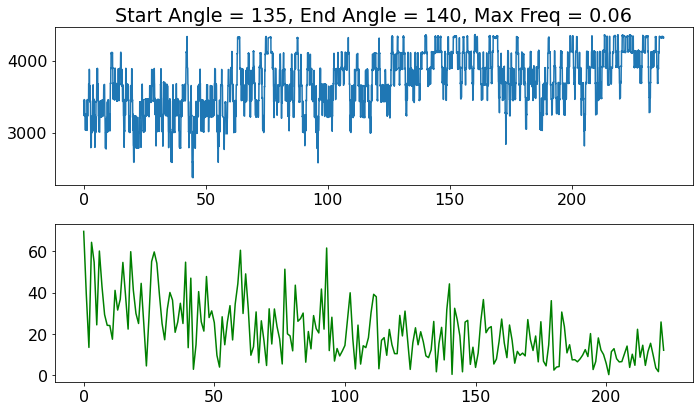

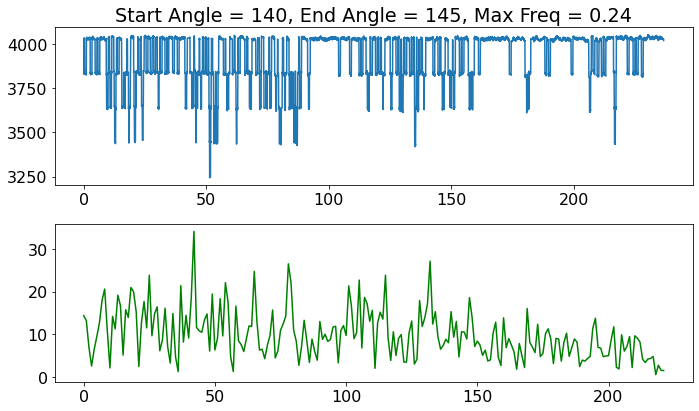

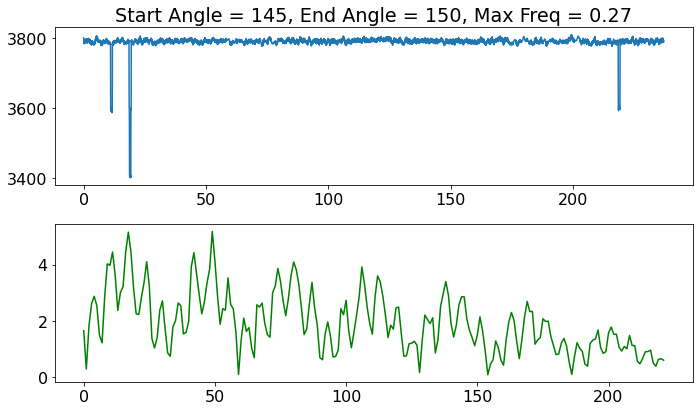

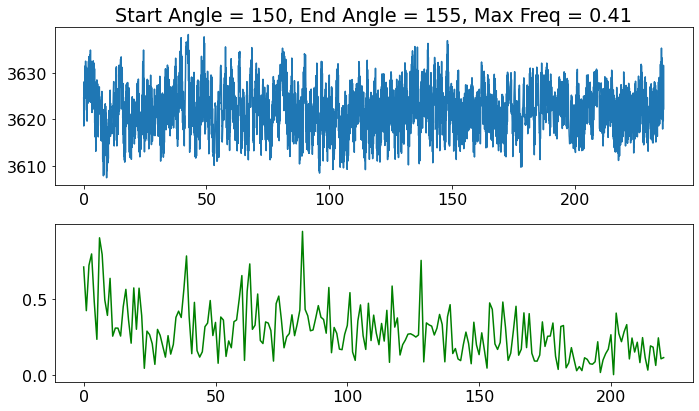

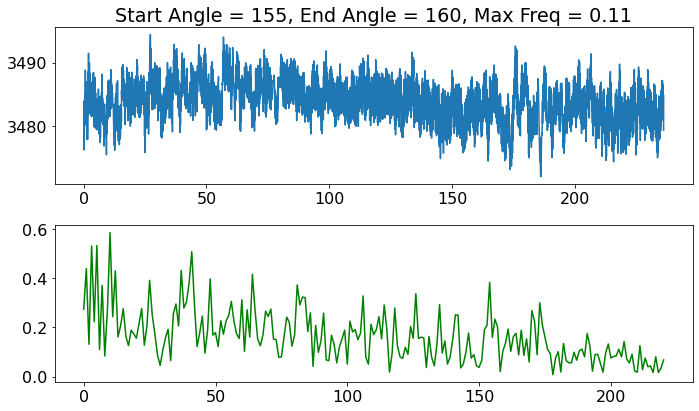

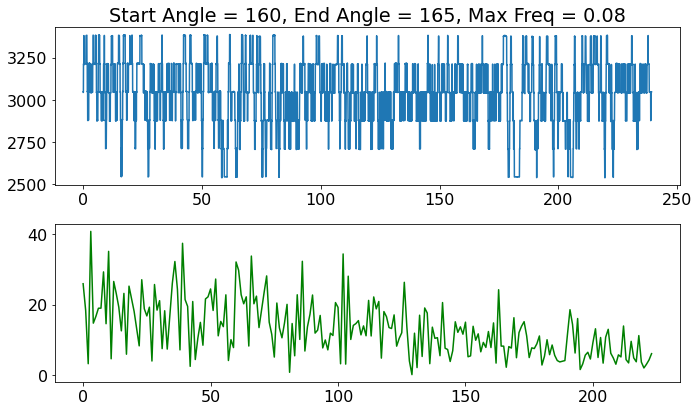

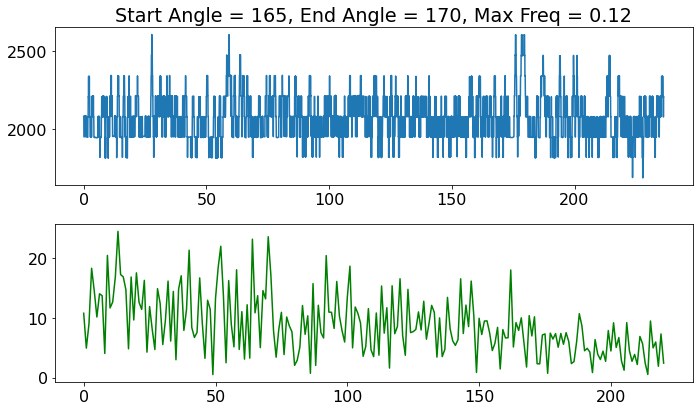

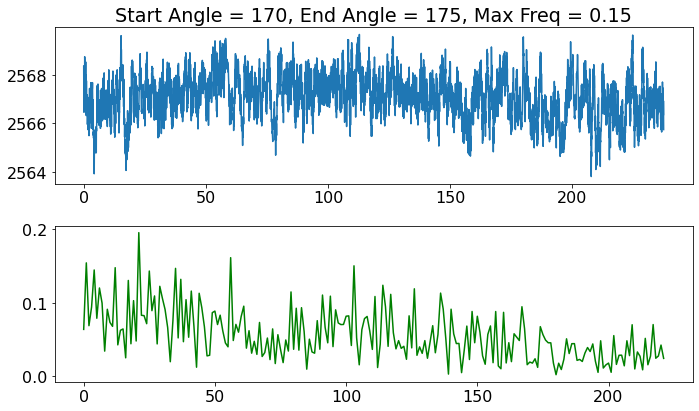

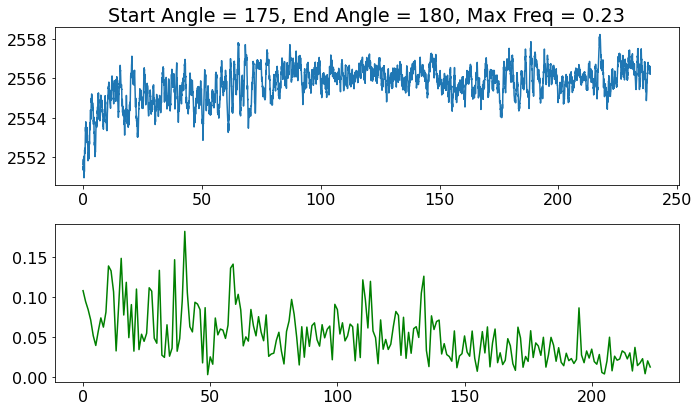

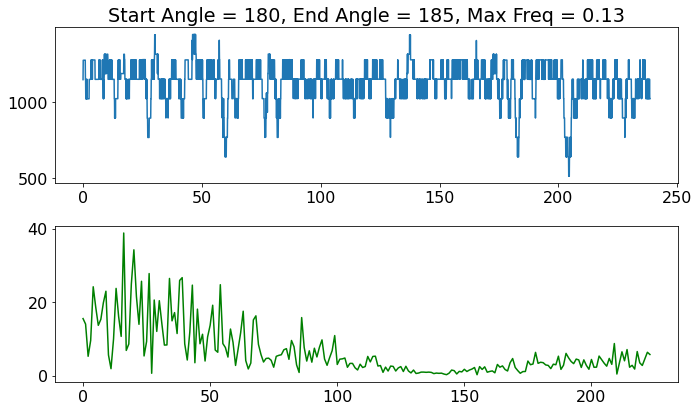

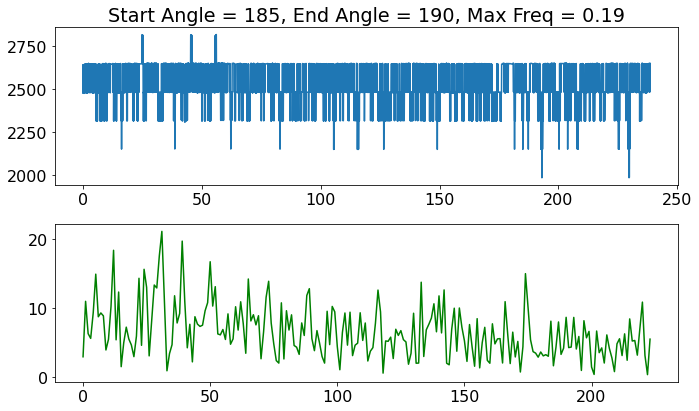

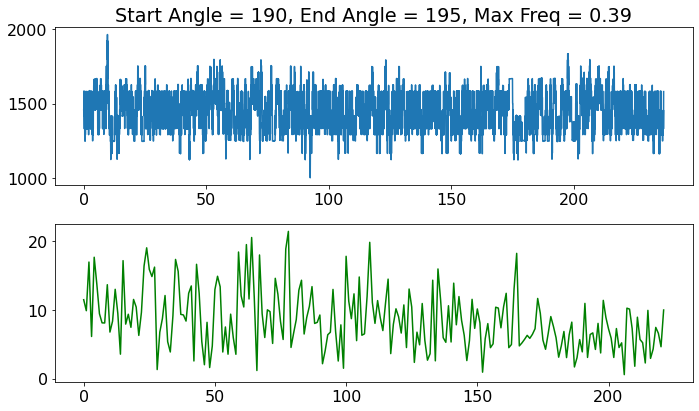

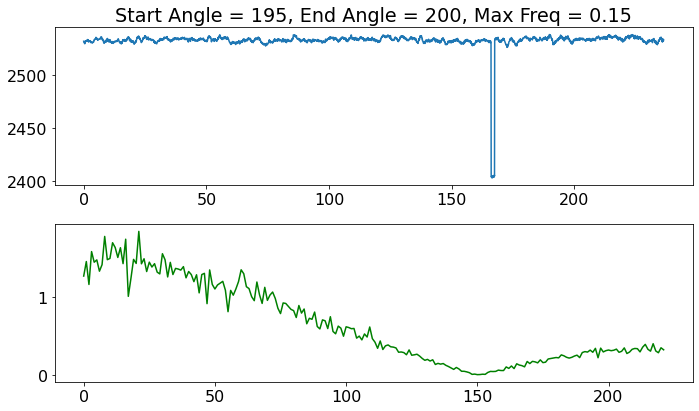

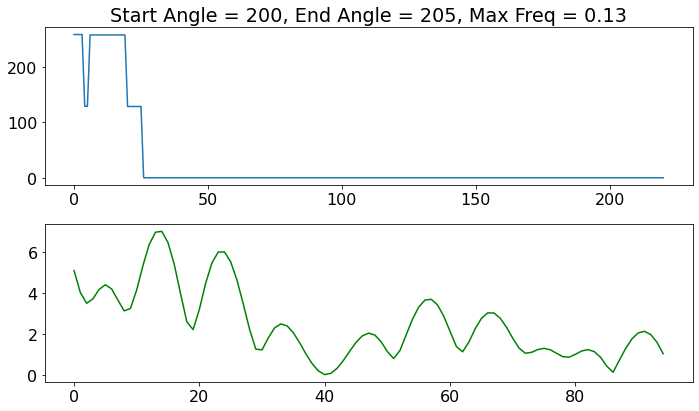

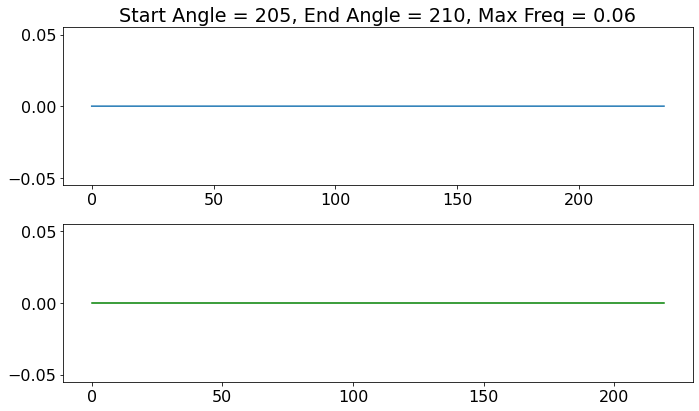

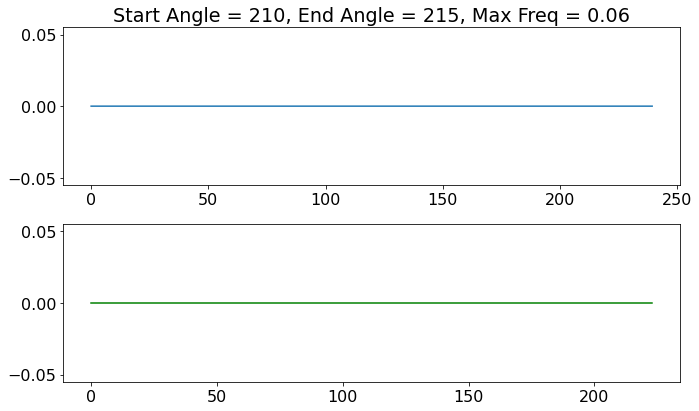

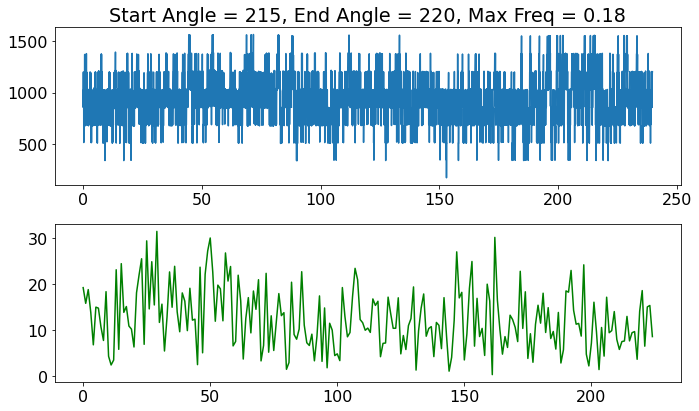

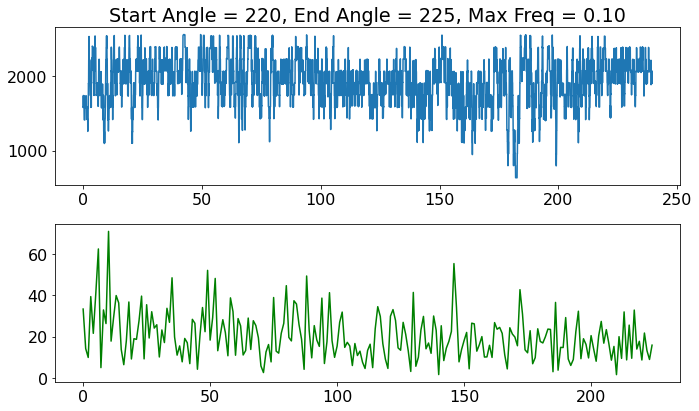

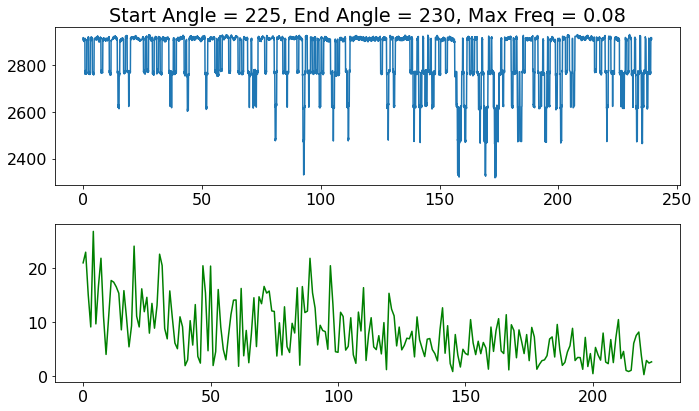

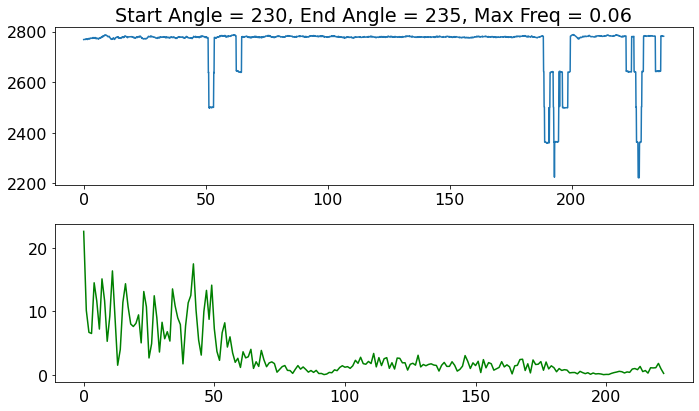

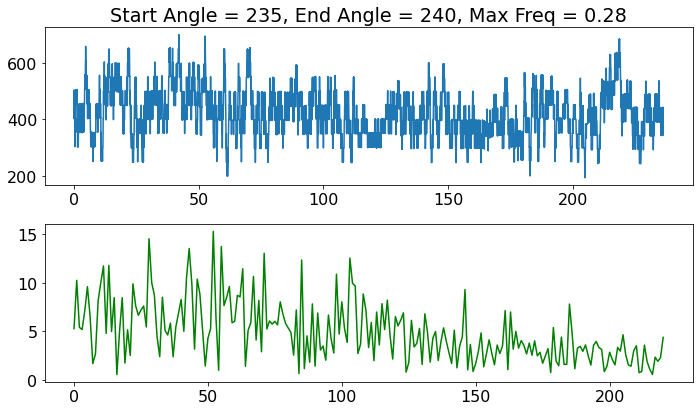

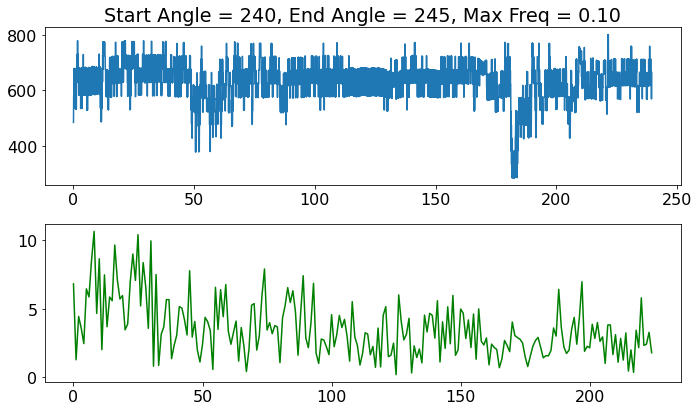

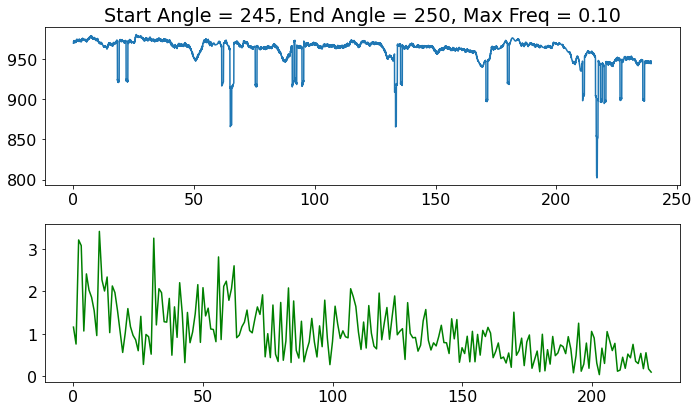

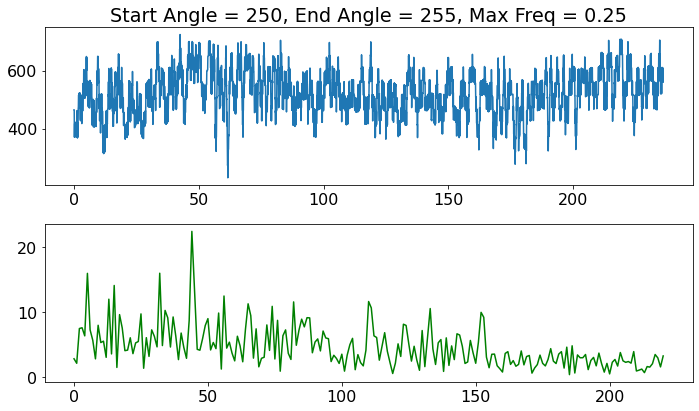

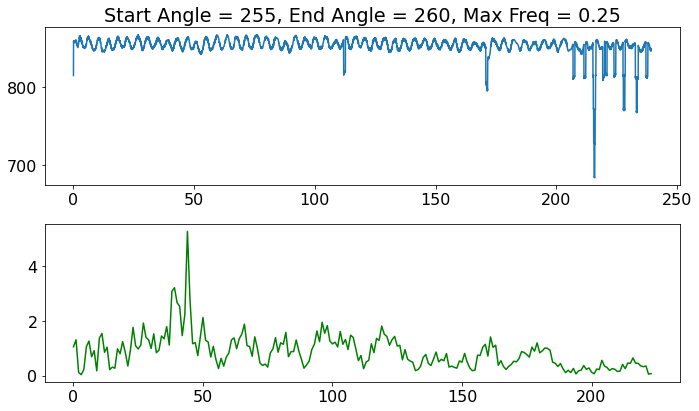

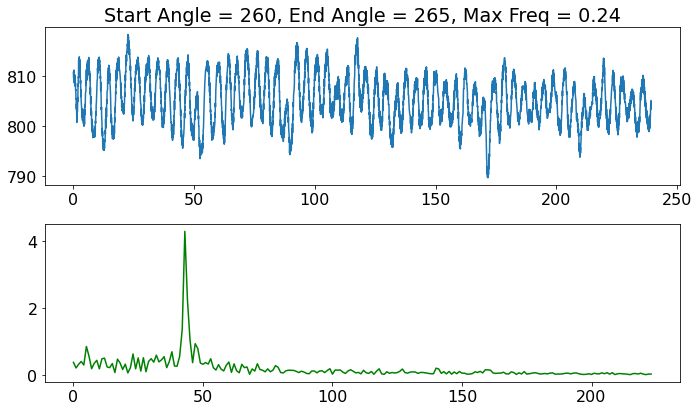

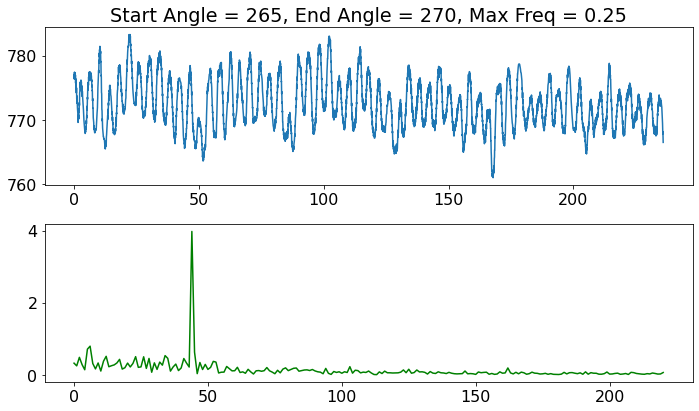

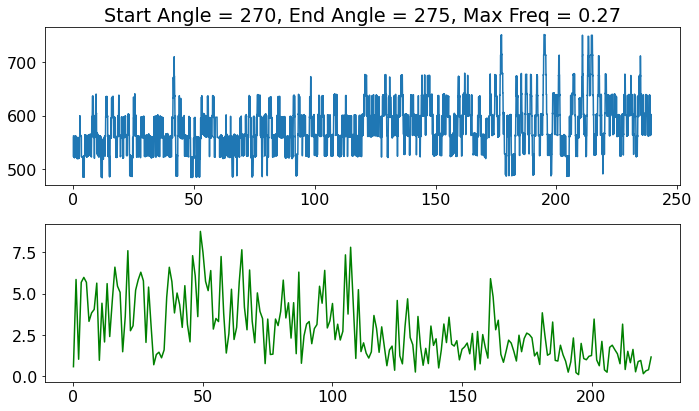

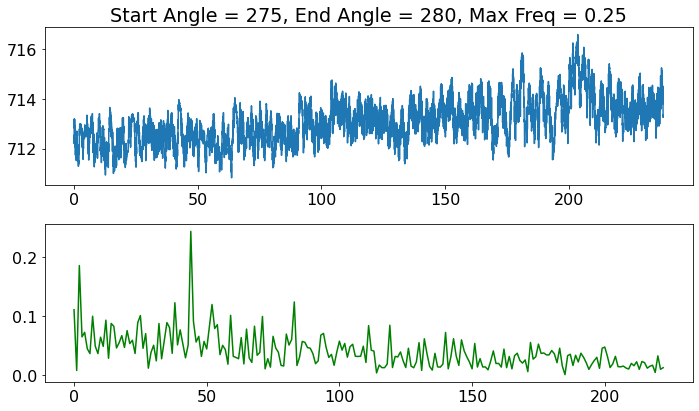

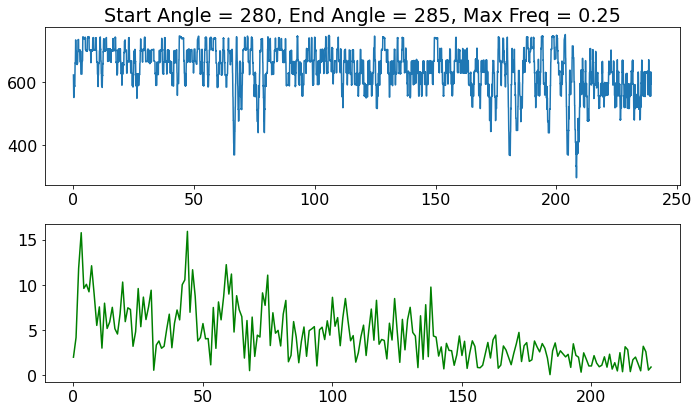

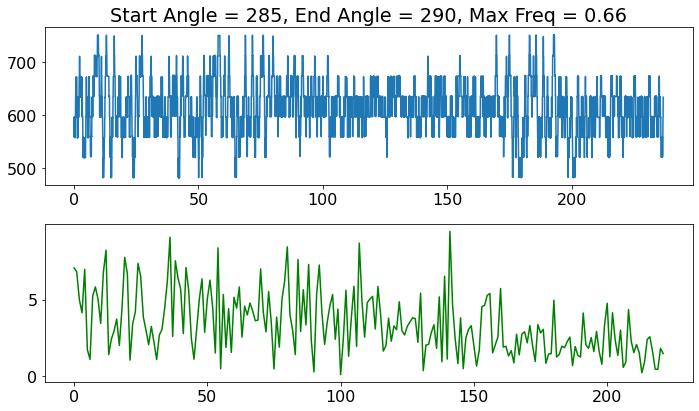

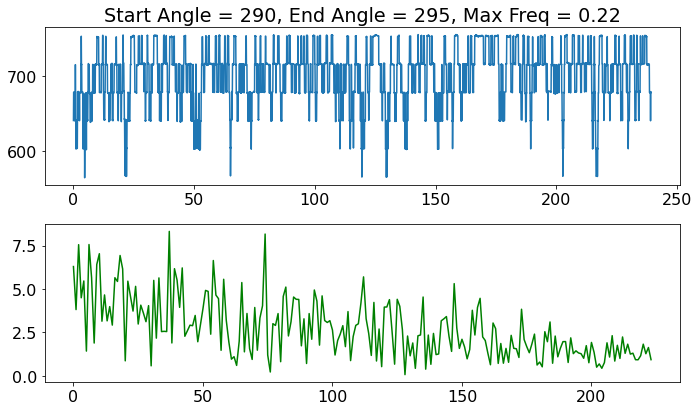

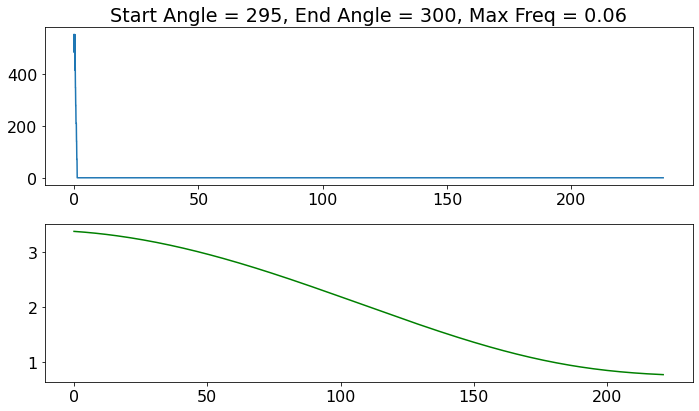

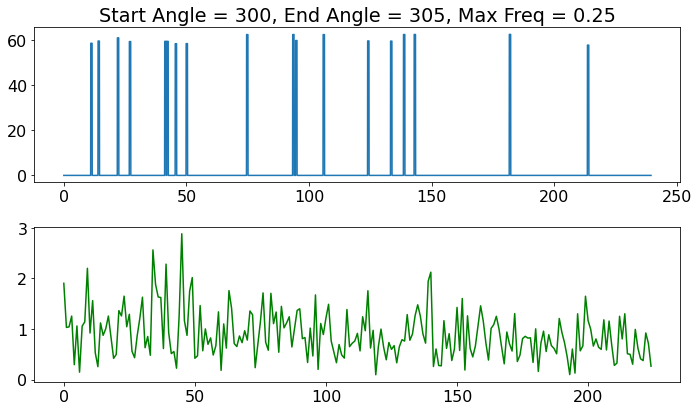

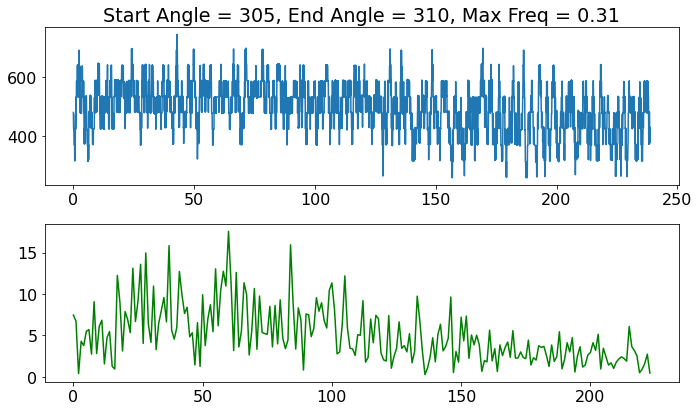

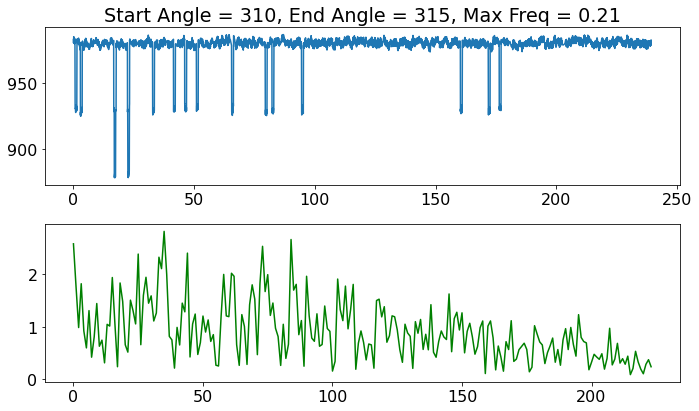

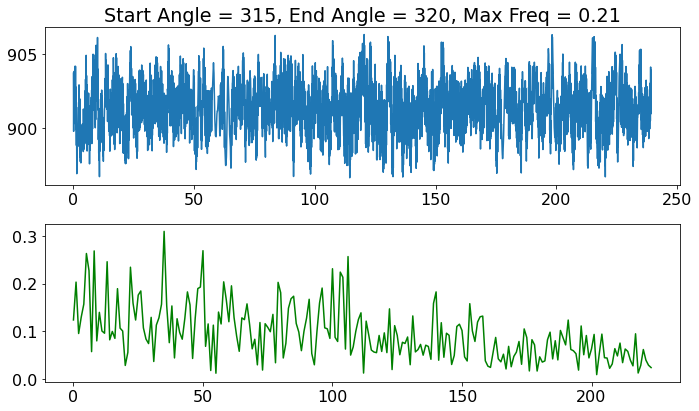

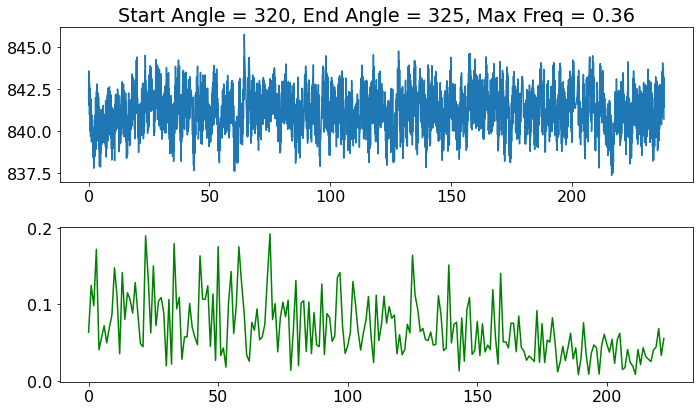

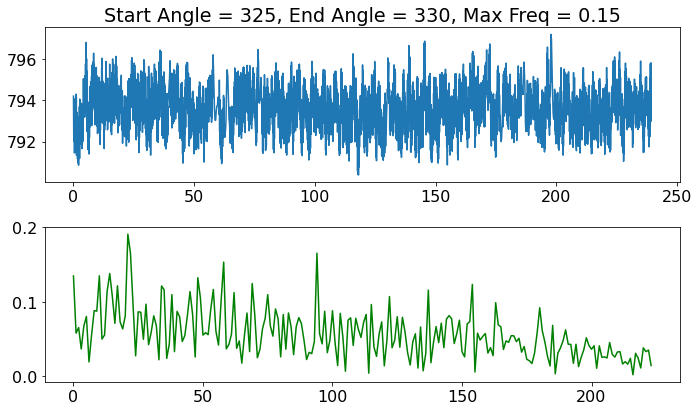

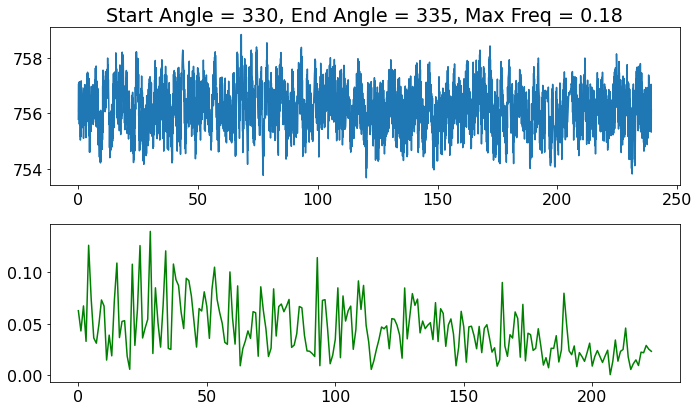

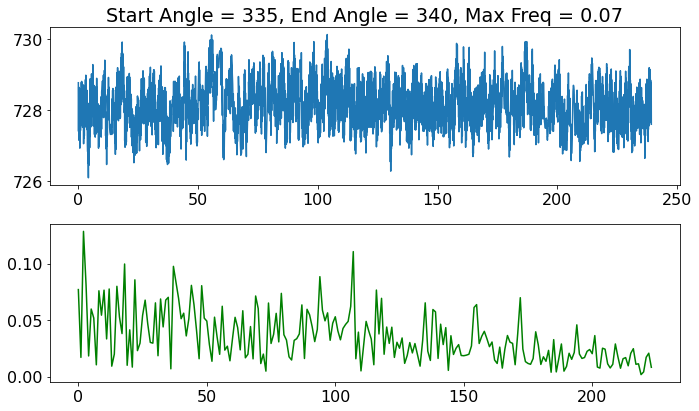

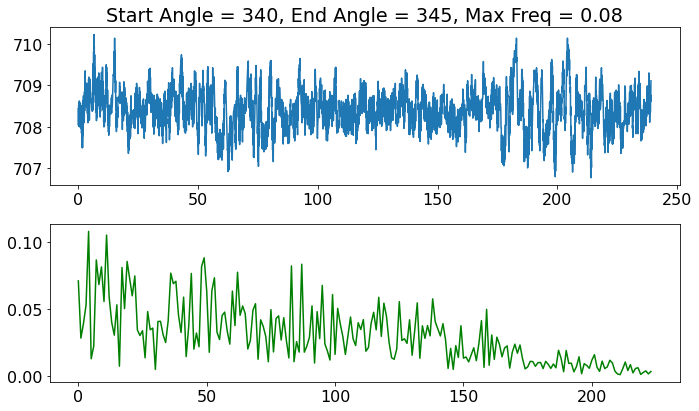

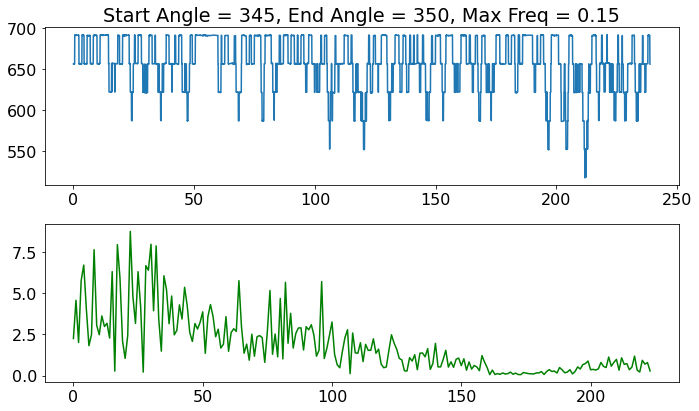

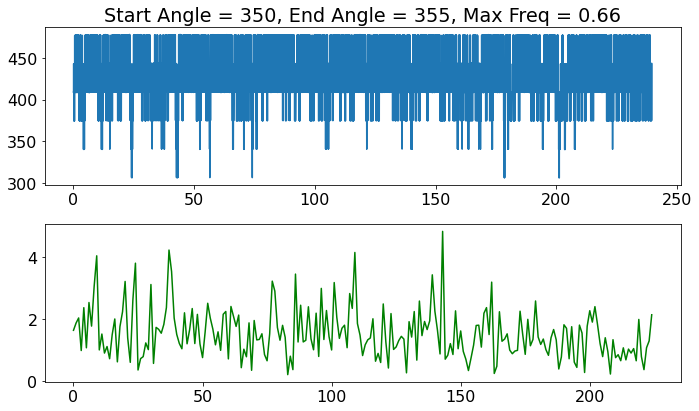

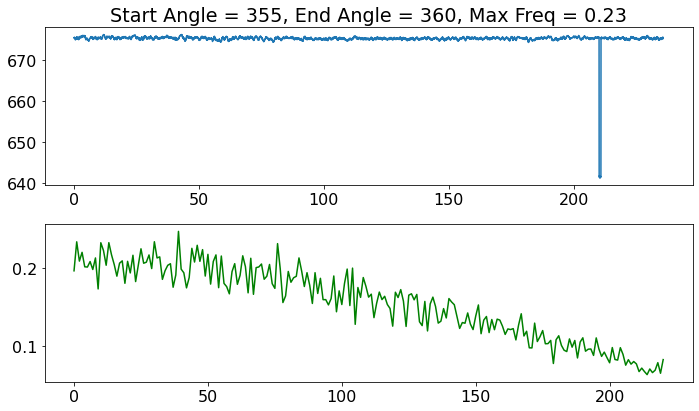

In [6]:
# RPLIDAR sleeping position 

df = pd.read_csv('tripod-2/aryan-1-vertical.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
elTime = 240 #time for which LIDAR was ON
stepAngle = 5
listofAngles = [(i,i+stepAngle) for i in range(0,360,stepAngle)]
for i in range(0,int(360/stepAngle)):
    try:
        startAngle, endAngle = listofAngles[i]
        sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
        selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
        t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
        
        
        #choose time stamp of data.
        
        
        

        startTime = 0 #in seconds
        timeUntil =  240 #in seconds
        selectedData = selectedData[startTime*sr:sr*timeUntil]
        t = t[startTime*sr:sr*timeUntil]
        #smooth the signal
        filter_window_size = 20
        dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
        t_ = t[:-filter_window_size+1]

        #get the frequency response
        F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
        fundamental = F[np.argmax(A[1:])+1]
        #if 0.2 <= fundamental <= 0.40:
        #print("SR = {}, Angle: {},{} Highest Freq Component {}".format(sr,startAngle,endAngle,fundamental))
        
        
        
        #get the peak of the signal
        #peak_signal = thresholding_algo(A[1:resolution*1], 5, 8, 0)
        
        #print("Breathing found between {} and {}".format(startAngle, endAngle))
        #plot the figures
        resolution = int(round(len(F)/max(F)))
        fig, ax = plt.subplots(2,1, figsize=(10,6))
        ax[0].plot(t_,dist)
        ax[0].set_title("Start Angle = {}, End Angle = {}, Max Freq = {:.2f}".format(startAngle, endAngle, F[np.argmax(A[15:resolution*1])+15]))
        
        #ax[1].plot(F[1:resolution*1],A[1:resolution*1],color="green")
        ax[1].plot(A[15:resolution*1],color="green")
        #ax[2].plot(F[1:resolution*1],peak_signal["signals"],color="red")
        #f, t_s, Sxx = signal.spectrogram(np.array(dist), fs = sr, nperseg=sr*20)
        #ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
        #ax[3].set_ylim(0,1)
        #print("Shape of input = {} and output = {}".format(A[1:resolution*1].shape,peak_signal["signals"].shape))
        fig.tight_layout()
     
    except Exception as e:
        print(e)

shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
attempt to get argmax of an empty sequence


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape


/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_40722/3008459427.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(8,4))


shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
shape mismatch: objects cannot be broadcast to a single shape
attempt 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


shape mismatch: objects cannot be broadcast to a single shape


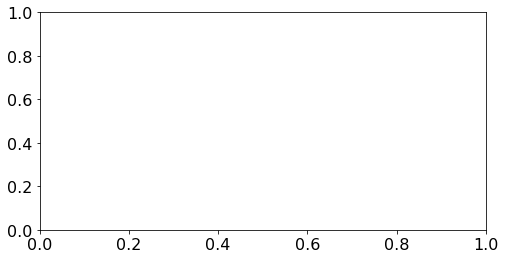

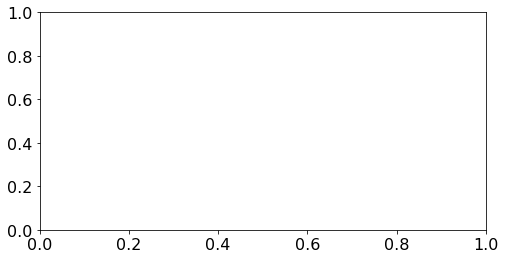

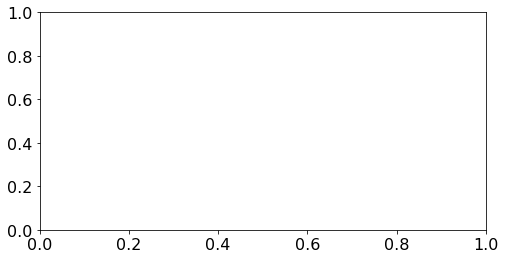

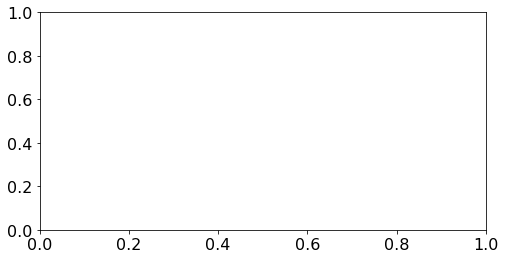

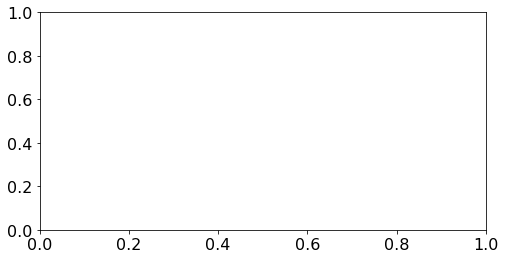

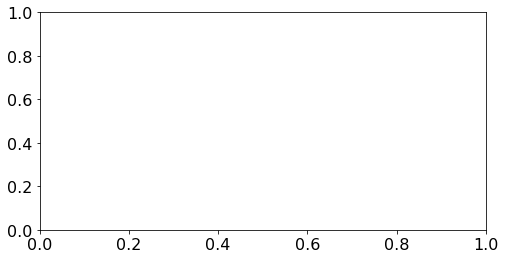

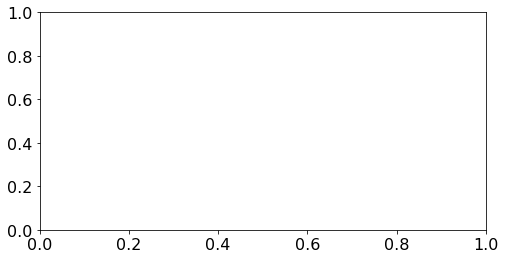

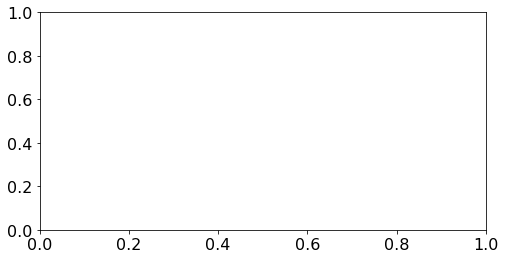

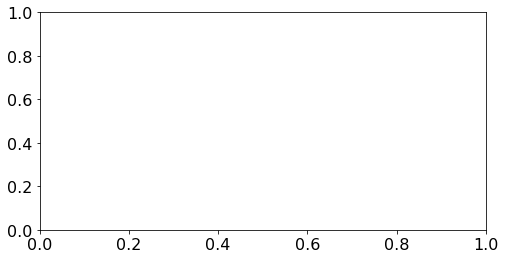

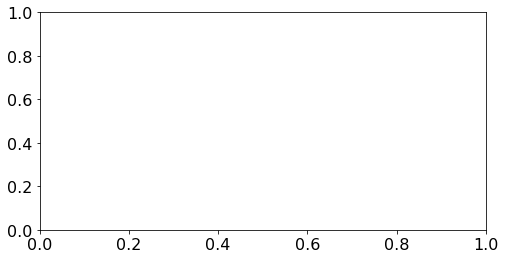

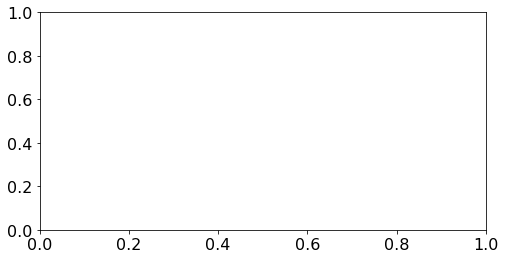

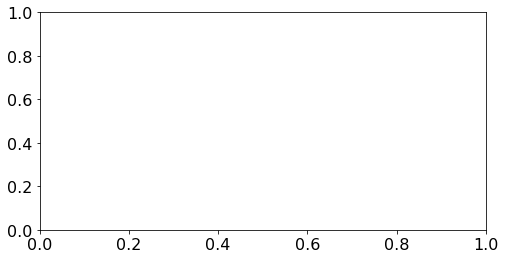

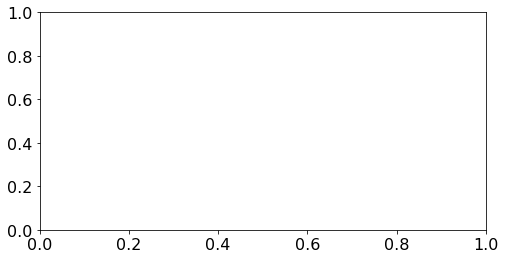

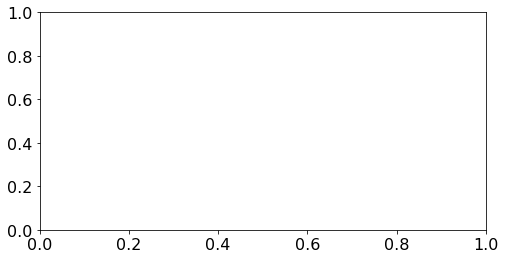

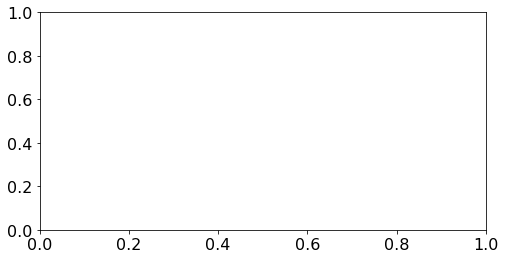

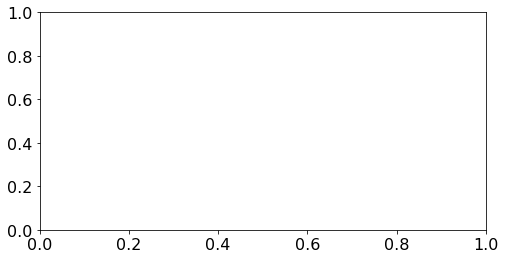

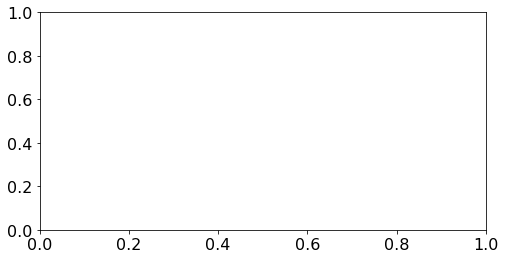

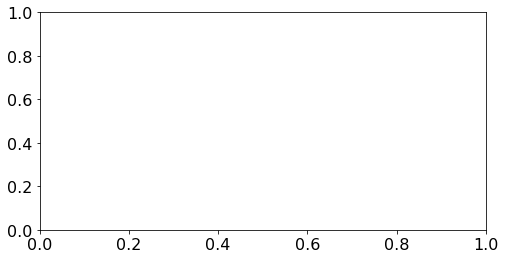

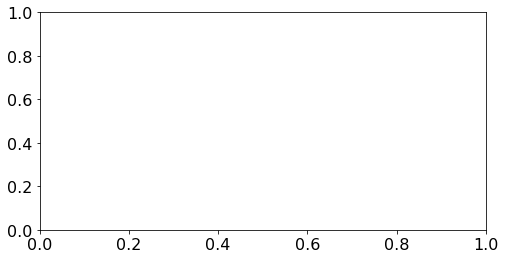

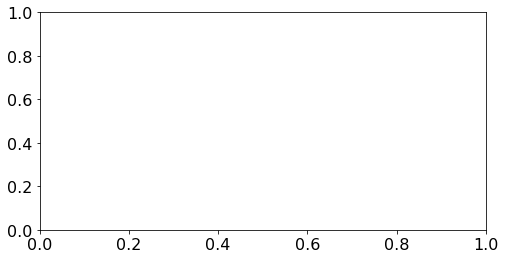

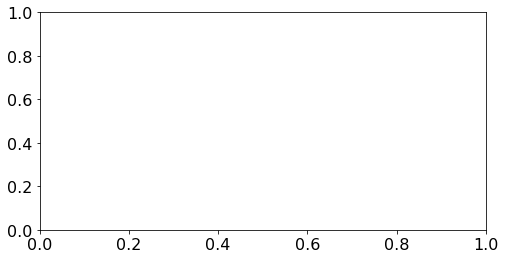

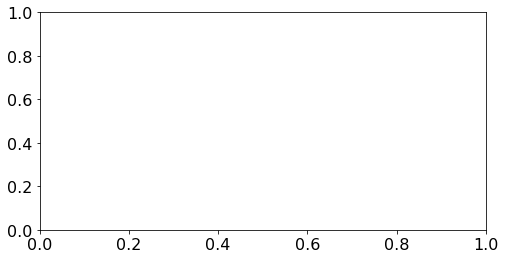

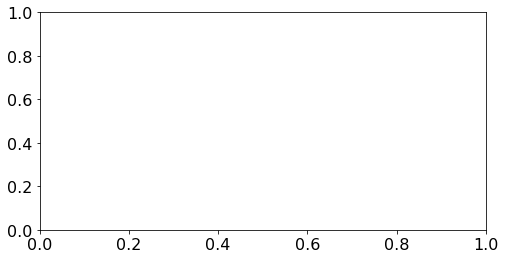

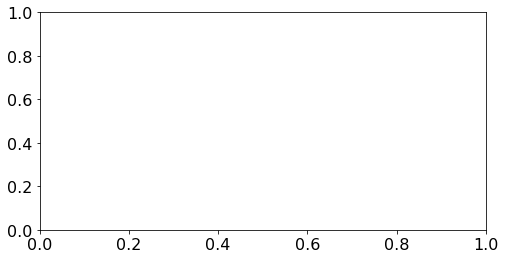

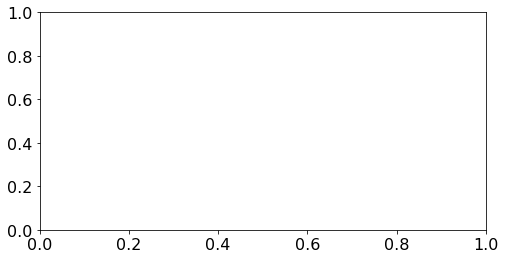

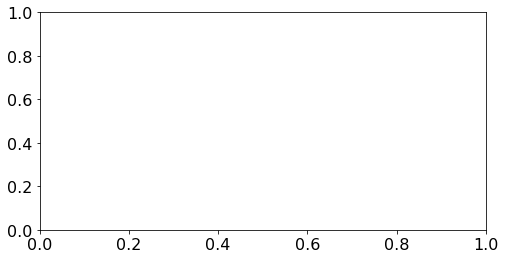

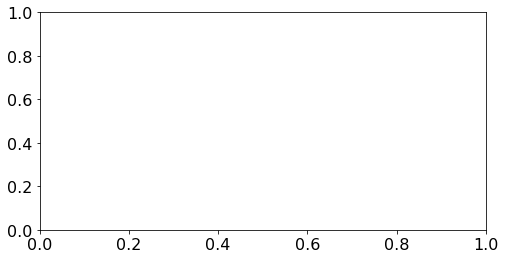

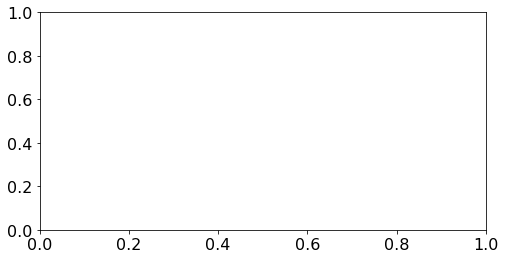

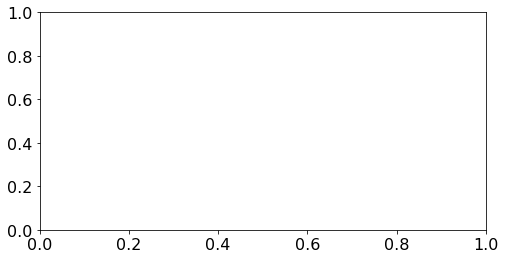

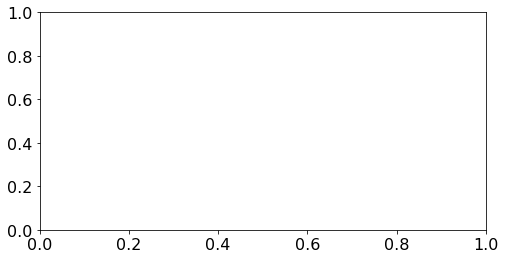

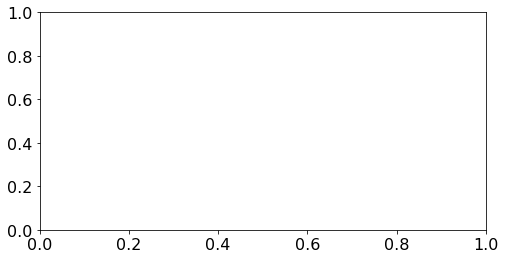

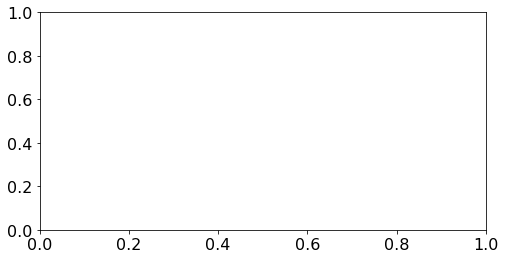

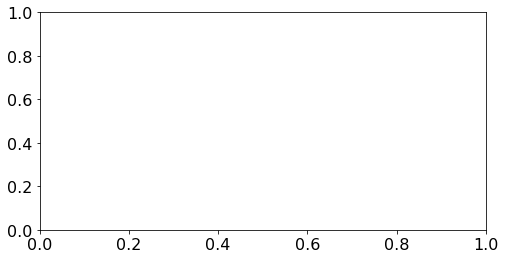

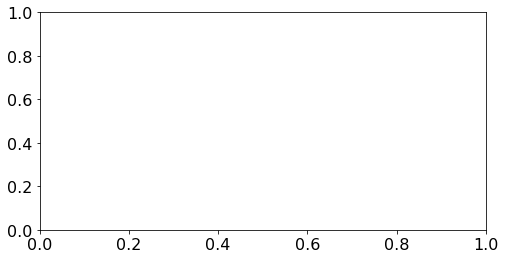

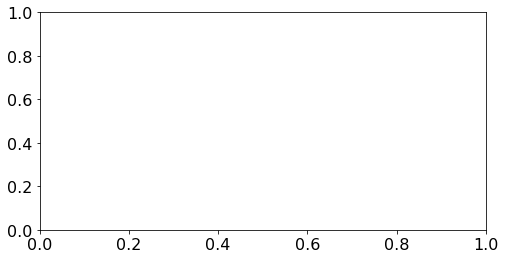

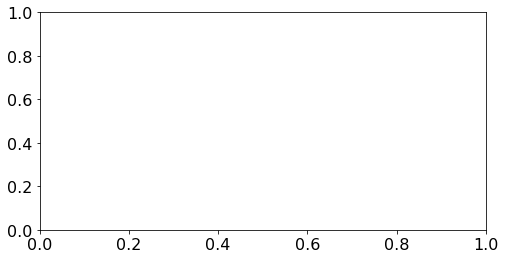

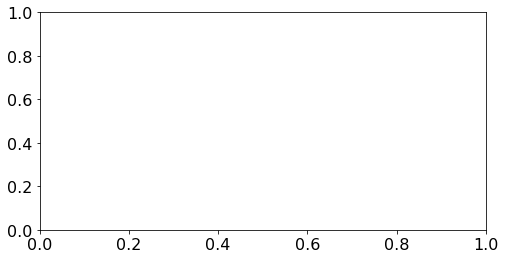

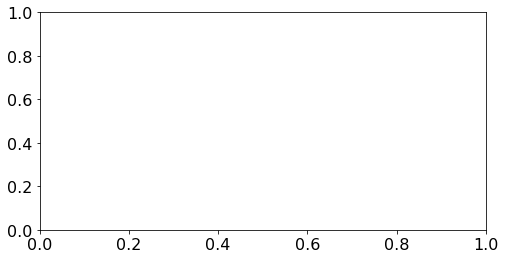

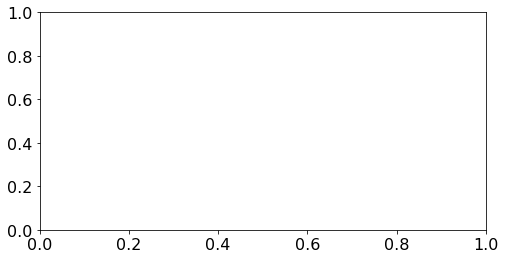

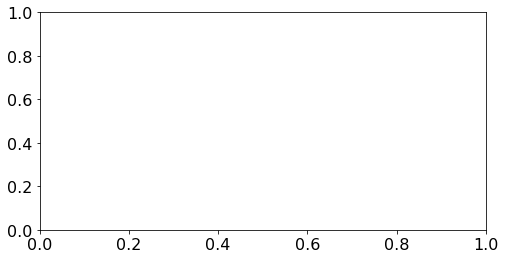

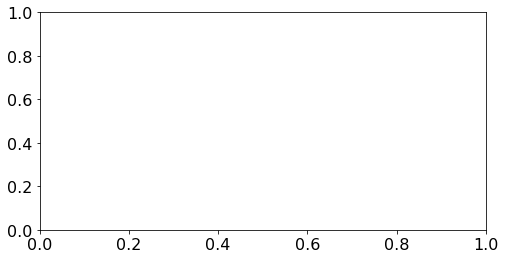

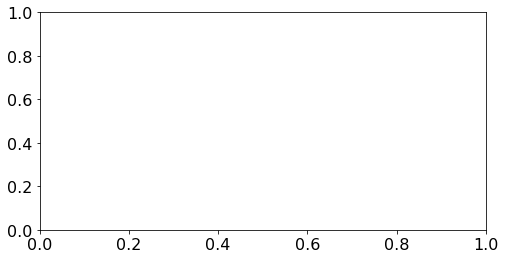

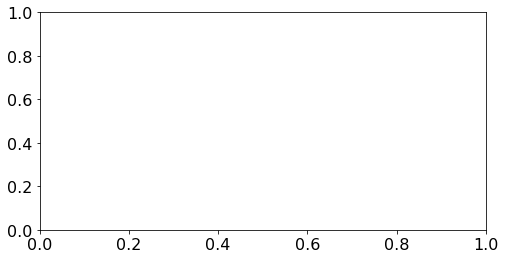

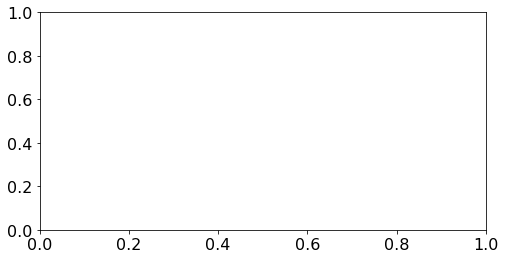

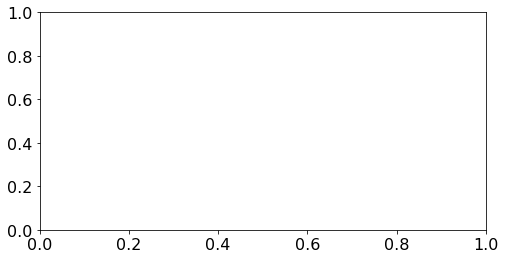

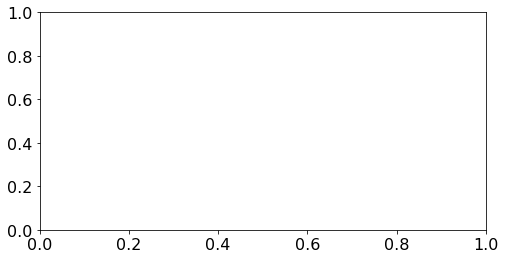

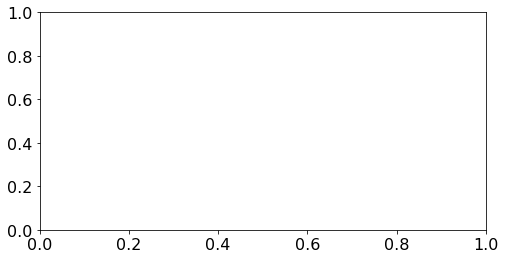

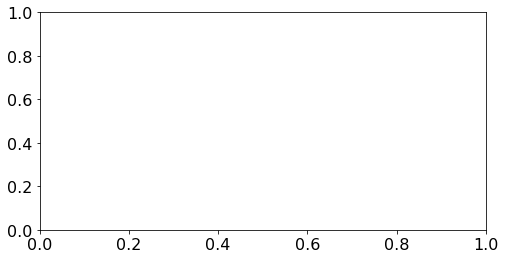

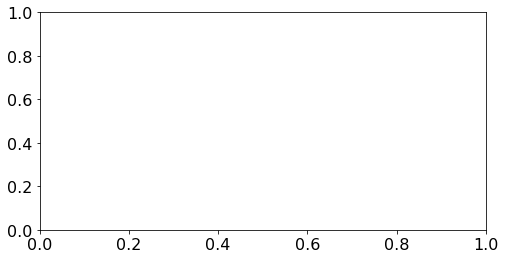

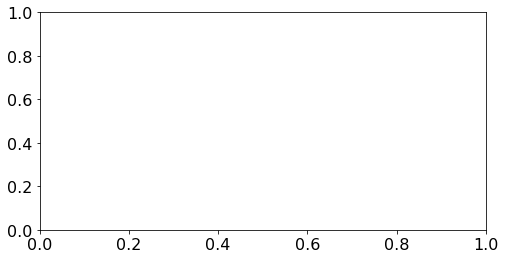

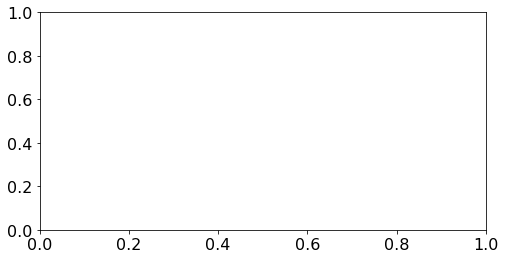

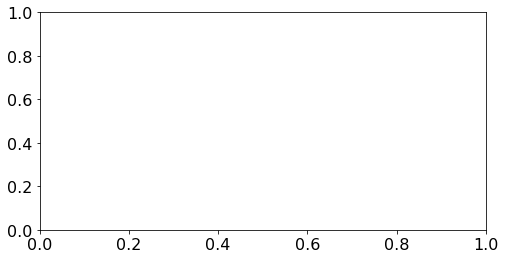

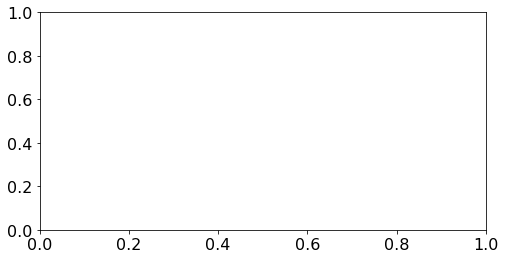

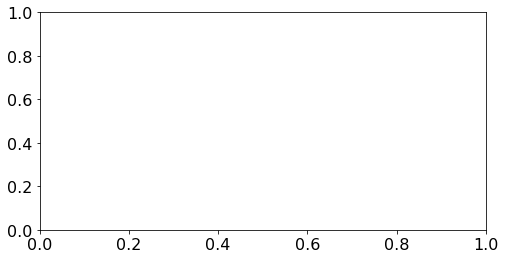

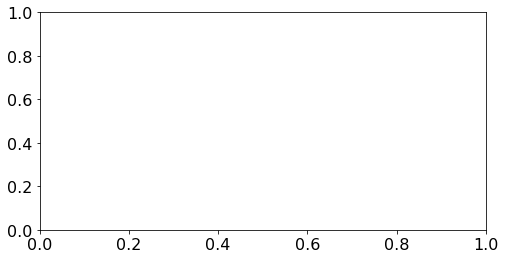

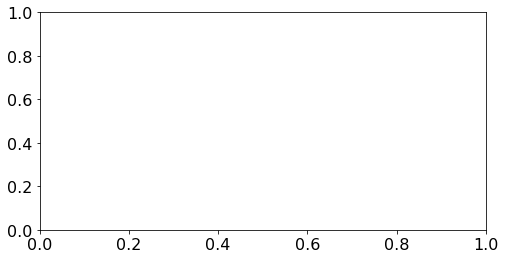

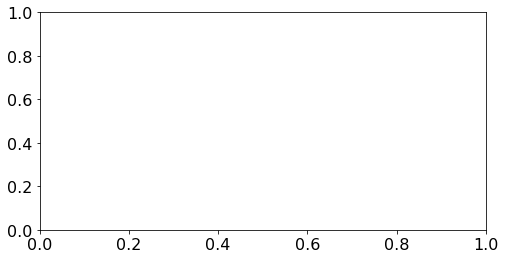

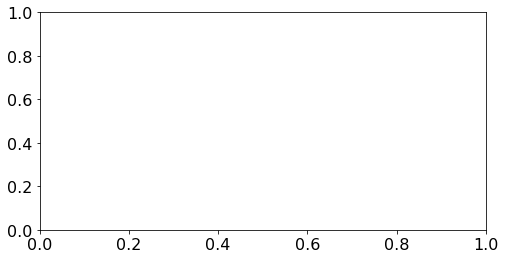

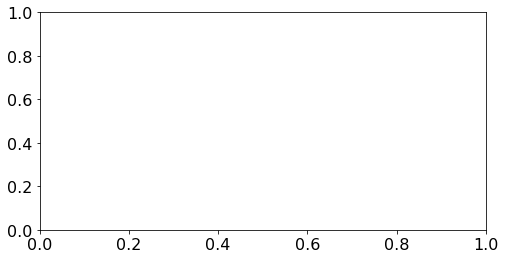

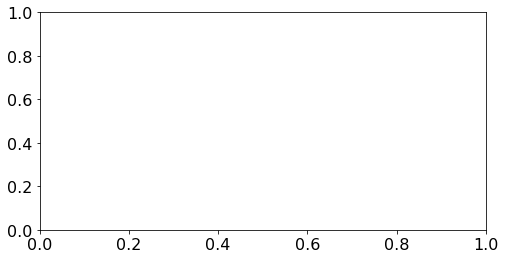

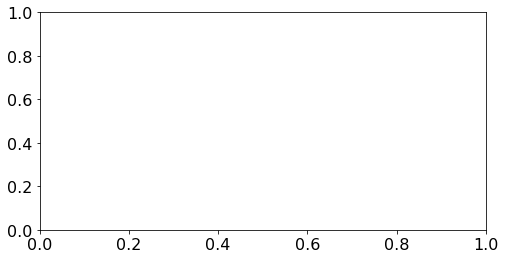

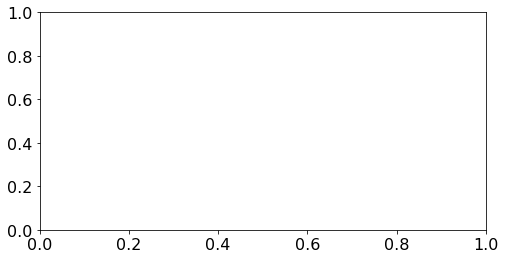

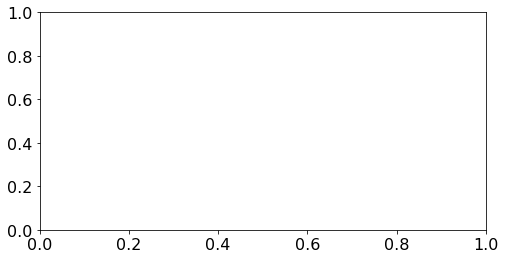

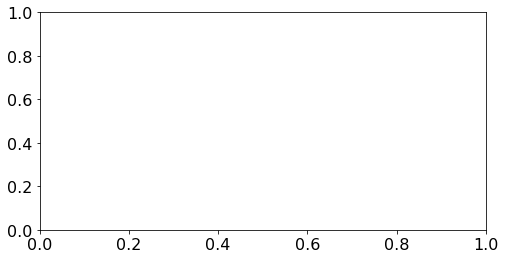

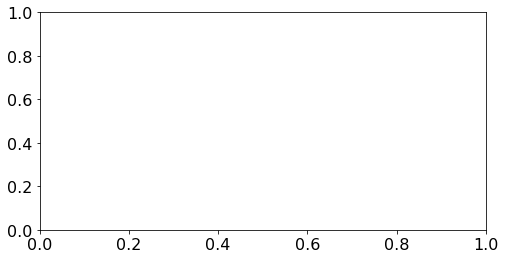

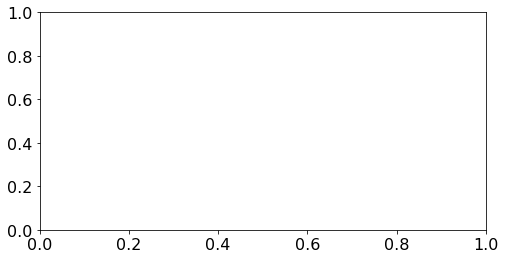

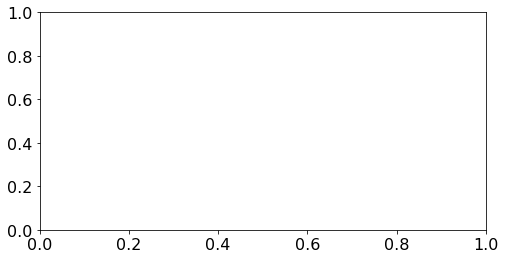

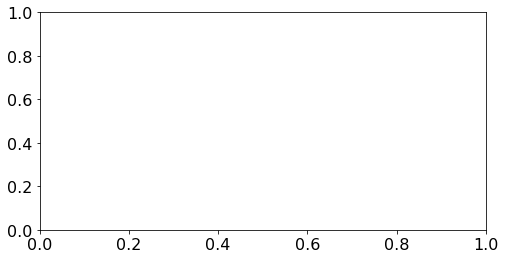

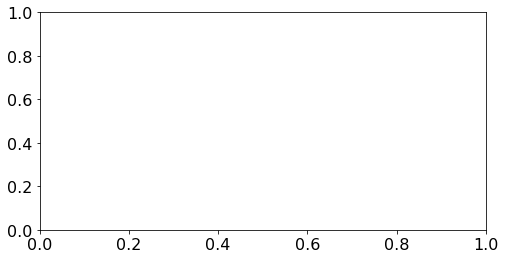

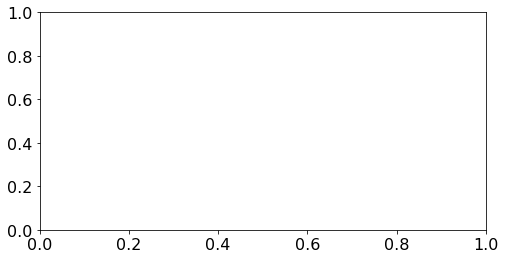

In [6]:
df = pd.read_csv('tripod-2/aryan-1-vertical.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
elTime = 240 #time for which LIDAR was ON
stepAngle = 5
listofAngles = [(i,i+stepAngle) for i in range(0,360,stepAngle)]
for i in range(0,int(360/stepAngle)):
    try:
        startAngle, endAngle = listofAngles[i]
        sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
        selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
        t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
        
        #select the duration
        duration = 30 #in seconds
        timeStamp = [(i,i+duration) for i in range(0,elTime,duration)]
        
        varArray = []
        maxFreq = []
        for i in timeStamp:
            startTime, timeUntil = i
            selectedData_ = selectedData[startTime*sr:sr*timeUntil]
            t = t[startTime*sr:sr*timeUntil]
            #smooth the signal
            filter_window_size = 10
            dist = np.convolve(selectedData_['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
            t_ = t[:-filter_window_size+1]

            #get the frequency response
            F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
            resolution = int(round(len(F)/max(F)))
            
            #for one particular angle, we are suppose to find variance across time
            varArray.append(np.var(A[15:resolution*1]))
            
            #max freq array
            maxFreq.append(F[np.argmax(A[15:resolution*1])+1])
            
            
        #plot the variance
        fig, ax = plt.subplots(1,1, figsize=(8,4))
        ax.bar([str(i) for i in timeStamp], varArray, width=0.4)
        ax.set_title("Start Angle = {}, End Angle = {}".format(startAngle, endAngle))
        ax.set_ylim(0,1)
    except Exception as e:
        print(e) 

In [4]:
duration = 30
elTime = 240
timeStamp = [(i,i+duration) for i in range(0,elTime,duration)]

In [10]:
len(timeStamp)

8

In [12]:
len(varArray)

8

<BarContainer object of 8 artists>

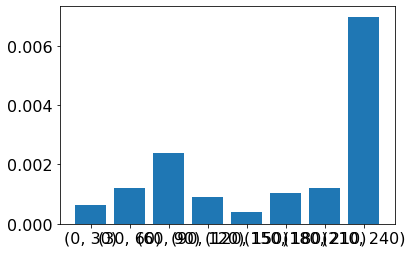

In [15]:
plt.bar([str(i) for i in timeStamp],varArray)